# Use TRPO to Play Acrobot-v1

PyTorch version

In [1]:
%matplotlib inline

import sys
import logging
import itertools

import numpy as np
np.random.seed(0)
import pandas as pd
import scipy.signal as signal
import gym
import matplotlib.pyplot as plt
import torch
torch.manual_seed(0)
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.distributions as distributions

logging.basicConfig(level=logging.DEBUG,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

In [2]:
env = gym.make('Acrobot-v1')
env.seed(0)
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])
for key in vars(env.spec):
    logging.info('%s: %s', key, vars(env.spec)[key])

11:45:19 [INFO] env: <AcrobotEnv<Acrobot-v1>>
11:45:19 [INFO] action_space: Discrete(3)
11:45:19 [INFO] observation_space: Box(-28.274333953857422, 28.274333953857422, (6,), float32)
11:45:19 [INFO] reward_range: (-inf, inf)
11:45:19 [INFO] metadata: {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 15}
11:45:19 [INFO] _max_episode_steps: 500
11:45:19 [INFO] _elapsed_steps: None
11:45:19 [INFO] id: Acrobot-v1
11:45:19 [INFO] entry_point: gym.envs.classic_control:AcrobotEnv
11:45:19 [INFO] reward_threshold: -100.0
11:45:19 [INFO] nondeterministic: False
11:45:19 [INFO] max_episode_steps: 500
11:45:19 [INFO] _kwargs: {}
11:45:19 [INFO] _env_name: Acrobot


In [3]:
class PPOReplayer:
    def __init__(self):
        self.fields = ['state', 'action', 'prob', 'advantage', 'return']
        self.memory = pd.DataFrame(columns=self.fields)

    def store(self, df):
        self.memory = pd.concat([self.memory, df[self.fields]], ignore_index=True)

    def sample(self, size):
        indices = np.random.choice(self.memory.shape[0], size=size)
        return (np.stack(self.memory.loc[indices, field]) for field in
                self.fields)

In [4]:
def conjugate_gradient(f, b, iter_count=10, epsilon=1e-12, tol=1e-6):
    x = b * 0.
    r = b.clone()
    p = b.clone()
    rho = torch.dot(r, r)
    for i in range(iter_count):
        z = f(p)
        alpha = rho / (torch.dot(p, z) + epsilon)
        x += alpha * p
        r -= alpha * z
        rho_new = torch.dot(r, r)
        p = r + (rho_new / rho) * p
        rho = rho_new
        if rho < tol:
            break
    return x, f(x)

In [5]:
class TRPOAgent:
    def __init__(self, env):
        self.gamma = 0.99

        self.replayer = PPOReplayer()
        self.trajectory = []

        self.actor_net = self.build_net(
                input_size=env.observation_space.shape[0],
                hidden_sizes=[100,],
                output_size=env.action_space.n, output_activator=nn.Softmax(1))
        self.max_kl = 0.01
        self.critic_net = self.build_net(
                input_size=env.observation_space.shape[0],
                hidden_sizes=[100,])
        self.critic_optimizer = optim.Adam(self.critic_net.parameters(), 0.002)
        self.critic_loss = nn.MSELoss()

    def build_net(self, input_size, hidden_sizes, output_size=1,
            output_activator=None):
        layers = []
        for input_size, output_size in zip(
                [input_size,] + hidden_sizes, hidden_sizes + [output_size,]):
            layers.append(nn.Linear(input_size, output_size))
            layers.append(nn.ReLU())
        layers = layers[:-1]
        if output_activator:
            layers.append(output_activator)
        net = nn.Sequential(*layers)
        return net

    def reset(self, mode=None):
        self.mode = mode
        if self.mode == 'train':
            self.trajectory = []

    def step(self, observation, reward, done):
        state_tensor = torch.as_tensor(observation, dtype=torch.float).unsqueeze(0)
        prob_tensor = self.actor_net(state_tensor)
        action_tensor = distributions.Categorical(prob_tensor).sample()
        action = action_tensor.numpy()[0]
        if self.mode == 'train':
            self.trajectory += [observation, reward, done, action]
        return action

    def close(self):
        if self.mode == 'train':
            self.save_trajectory_to_replayer()
            if len(self.replayer.memory) >= 1000:
                for batch in range(5): # learn multiple times
                    self.learn()
                self.replayer = PPOReplayer() # reset replayer after the agent changes itself

    def save_trajectory_to_replayer(self):
        df = pd.DataFrame(
                np.array(self.trajectory, dtype=object).reshape(-1, 4),
                columns=['state', 'reward', 'done', 'action'])
        state_tensor = torch.as_tensor(np.stack(df['state']), dtype=torch.float)
        action_tensor = torch.as_tensor(df['action'], dtype=torch.long)
        v_tensor = self.critic_net(state_tensor)
        df['v'] = v_tensor.detach().numpy()
        prob_tensor = self.actor_net(state_tensor)
        pi_tensor = prob_tensor.gather(-1, action_tensor.unsqueeze(1)).squeeze(1)
        df['prob'] = pi_tensor.detach().numpy()
        df['next_v'] = df['v'].shift(-1).fillna(0.)
        df['u'] = df['reward'] + self.gamma * df['next_v']
        df['delta'] = df['u'] - df['v']
        df['advantage'] = signal.lfilter([1.,], [1., -self.gamma],
                df['delta'][::-1])[::-1]
        df['return'] = signal.lfilter([1.,], [1., -self.gamma],
                df['reward'][::-1])[::-1]
        self.replayer.store(df)

    def learn(self):
        states, actions, old_pis, advantages, returns = \
                self.replayer.sample(size=64)
        state_tensor = torch.as_tensor(states, dtype=torch.float)
        action_tensor = torch.as_tensor(actions, dtype=torch.long)
        old_pi_tensor = torch.as_tensor(old_pis, dtype=torch.float)
        advantage_tensor = torch.as_tensor(advantages, dtype=torch.float)
        return_tensor = torch.as_tensor(returns, dtype=torch.float).unsqueeze(1)

        # train actor
        # ... calculate first order gradient: g
        all_pi_tensor = self.actor_net(state_tensor)
        pi_tensor = all_pi_tensor.gather(1, action_tensor.unsqueeze(1)).squeeze(1)
        surrogate_tensor = (pi_tensor / old_pi_tensor) * advantage_tensor
        loss_tensor = surrogate_tensor.mean()
        loss_grads = autograd.grad(loss_tensor, self.actor_net.parameters())
        loss_grad = torch.cat([grad.view(-1) for grad in loss_grads]).detach()
                # flatten for calculating conjugate gradient

        # ... calculate conjugate gradient: Fx = g
        def f(x): # calculate Fx
            prob_tensor = self.actor_net(state_tensor)
            prob_old_tensor = prob_tensor.detach()
            kld_tensor = (prob_old_tensor * torch.log(
                    (prob_old_tensor / prob_tensor).clamp(1e-6, 1e6))).sum(axis=1)
            kld_loss_tensor = kld_tensor.mean()
            grads = autograd.grad(kld_loss_tensor, self.actor_net.parameters(), create_graph=True)
            flatten_grad_tensor = torch.cat([grad.view(-1) for grad in grads])
            grad_matmul_x = torch.dot(flatten_grad_tensor, x)
            grad_grads = autograd.grad(grad_matmul_x, self.actor_net.parameters())
            flatten_grad_grad = torch.cat([grad.contiguous().view(-1) for grad in grad_grads]).detach()
            fx = flatten_grad_grad + x * 0.01
            return fx
        x, fx = conjugate_gradient(f, loss_grad)

        # ... calculate natural gradient: sqrt(...) g
        natural_gradient_tensor = torch.sqrt(2 * self.max_kl / torch.dot(fx, x)) * x

        # ... line search
        def set_actor_net_params(flatten_params):
                # auxiliary function to overwrite actor_net
            begin = 0
            for param in self.actor_net.parameters():
                end = begin + param.numel()
                param.data.copy_(flatten_params[begin:end].view(param.size()))
                begin = end

        old_param = torch.cat([param.view(-1) for param in self.actor_net.parameters()])
        expected_improve = torch.dot(loss_grad, natural_gradient_tensor)
        for learning_step in [0.,] + [.5 ** j for j in range(10)]:
            new_param = old_param + learning_step * natural_gradient_tensor
            set_actor_net_params(new_param)
            all_pi_tensor = self.actor_net(state_tensor)
            new_pi_tensor = all_pi_tensor.gather(1, action_tensor.unsqueeze(1)).squeeze(1)
            new_pi_tensor = new_pi_tensor.detach()
            surrogate_tensor = (new_pi_tensor / pi_tensor) * advantage_tensor
            objective = surrogate_tensor.mean().item()
            if np.isclose(learning_step, 0.):
                old_objective = objective
            else:
                if objective - old_objective > 0.1 * expected_improve * learning_step:
                    break # success, keep the weight
        else:
            set_actor_net_params(old_param)

        # train critic
        pred_tensor = self.critic_net(state_tensor)
        critic_loss_tensor = self.critic_loss(pred_tensor, return_tensor)
        self.critic_optimizer.zero_grad()
        critic_loss_tensor.backward()
        self.critic_optimizer.step()


agent = TRPOAgent(env)

11:45:19 [INFO] ==== train ====
11:45:19 [INFO] NumExpr defaulting to 8 threads.
11:45:19 [DEBUG] train episode 0: reward = -500.00, steps = 500
11:45:20 [DEBUG] train episode 1: reward = -500.00, steps = 500
11:45:20 [DEBUG] train episode 2: reward = -500.00, steps = 500
11:45:21 [DEBUG] train episode 3: reward = -500.00, steps = 500
11:45:21 [DEBUG] train episode 4: reward = -500.00, steps = 500
11:45:22 [DEBUG] train episode 5: reward = -500.00, steps = 500
11:45:22 [DEBUG] train episode 6: reward = -371.00, steps = 372
11:45:23 [DEBUG] train episode 7: reward = -344.00, steps = 345
11:45:23 [DEBUG] train episode 8: reward = -311.00, steps = 312
11:45:23 [DEBUG] train episode 9: reward = -286.00, steps = 287
11:45:24 [DEBUG] train episode 10: reward = -398.00, steps = 399
11:45:24 [DEBUG] train episode 11: reward = -282.00, steps = 283
11:45:25 [DEBUG] train episode 12: reward = -454.00, steps = 455
11:45:25 [DEBUG] train episode 13: reward = -467.00, steps = 468
11:45:25 [DEBUG] tr

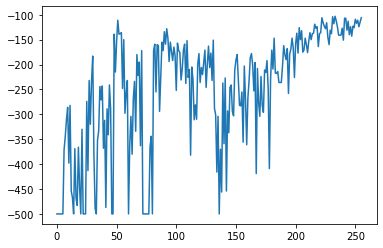

In [6]:
def play_episode(env, agent, max_episode_steps=None, mode=None, render=False):
    observation, reward, done = env.reset(), 0., False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, done)
        if render:
            env.render()
        if done:
            break
        observation, reward, done, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
        if max_episode_steps and elapsed_steps >= max_episode_steps:
            break
    agent.close()
    return episode_reward, elapsed_steps


logging.info('==== train ====')
episode_rewards = []
for episode in itertools.count():
    episode_reward, elapsed_steps = play_episode(env.unwrapped, agent,
            max_episode_steps=env._max_episode_steps, mode='train')
    episode_rewards.append(episode_reward)
    logging.debug('train episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-10:]) > -120:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.debug('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

In [7]:
env.close()